In [1]:
import pandas as pd
import random
import os
os.getcwd()

'/Users/harasim/Documents/repos/iRealPro'

# Read data into a list of dictionaries

In [2]:
data = open('LausanneJazzTreebank/data.csv', 'r').readlines()

tuneliness = []
tunelines = []
for line in map(lambda line: line.strip(';\n').split(';'), data):
    if line[0] == 'NEWTUNE':
        tuneliness.append(tunelines)
        tunelines = []
    else:
        tunelines.append(line)
tuneliness.append(tunelines)
        
def lines_to_dict(tunelines):
    d = {}
    for line in tunelines:
        if line[1:] == []:
            continue
        else:
            key = line[0][:-1]
            if key in ['title', 'tree', 'approved']:
                assert len(line) == 2
                d[key] = line[1]
            elif key == 'turnaround':
                assert len(line) == 2
                if line[1] in ['?','b']:
                    continue
                else:
                    d[key] = int(line[1])
            else:
                d[key] = ' '.join(line[1:])
    return d
        
tunes = list(map(lines_to_dict, tuneliness[1:]))

In [3]:
tunes[:3]

[{'title': 'Sweeping Up',
  'measures': '1 2 3 4 5 6 7',
  'beats': '1 1 1 1 1 1 1',
  'chords': 'D7 G^7 F#m7 Bm Em7 Bm Am7'},
 {'title': 'Red Clay',
  'measures': '1 2 3 3 4 4 5 6 6 7 8 8',
  'beats': '1 1 1 3 1 3 1 1 3 1 1 3',
  'chords': 'Cm7 Bbm7 Dbsus Ebsus Fsus Gsus Cm7 Bbm7 Eb7 Ab^7 D%7 G7',
  'turnaround': -1,
  'tree': '[.Cm7 [.G7 [.Gsus Cm7 [.Gsus [.Fsus [.Ebsus Bbm7 [.Ebsus Dbsus Ebsus ] ] Fsus ] Gsus ] ] [.G7 Cm7 [.G7 [.Ab^7 [.Eb7 Bbm7 Eb7 ] Ab^7 ] [.G7 D%7 G7 ] ] ] ] Cm7 ]'},
 {'title': "Bessie's Blues",
  'measures': '1 2 3 4 5 6 7 8 9 10 11 12',
  'beats': '1 1 1 1 1 1 1 1 1 1 1 1',
  'chords': 'Eb7 Ab7 Eb7 Eb7 Ab7 Ab7 Eb7 Eb7 Bb7 Ab7 Eb7 Bb7'}]

# Read metadata into a dataframe

In [4]:
metadata = pd.read_csv('LausanneJazzTreebank/metadata.csv', sep=';')
metadata = metadata[metadata['title'] != 'Ruby, My Dear']

assert all([tune['title'] for tune in tunes] == metadata['title'])

In [5]:
metadata.head(3)

,title,composers,year,meter,key,length
0,Sweeping Up,"Swallow, Steve",1975,3/4,G,7
1,Red Clay,"Hubbard, Freddie",1970,4/4,c,11
2,Bessie's Blues,"Coltrane, John",1964,4/4,E-,12


# Insert metadata into tunes (mutates tunes)

In [6]:
def insert_metadata(tunedict, metarow):
    assert tunedict['title'] == metarow['title']
    for feature in ['composers', 'year', 'meter', 'key']:
        tunedict[feature] = metarow[feature]
    
for (tune, (i, meta)) in zip(tunes, list(metadata.iterrows())):
    insert_metadata(tune, meta)

In [7]:
tunes[:3]

[{'title': 'Sweeping Up',
  'measures': '1 2 3 4 5 6 7',
  'beats': '1 1 1 1 1 1 1',
  'chords': 'D7 G^7 F#m7 Bm Em7 Bm Am7',
  'composers': 'Swallow, Steve',
  'year': 1975,
  'meter': '3/4',
  'key': 'G'},
 {'title': 'Red Clay',
  'measures': '1 2 3 3 4 4 5 6 6 7 8 8',
  'beats': '1 1 1 3 1 3 1 1 3 1 1 3',
  'chords': 'Cm7 Bbm7 Dbsus Ebsus Fsus Gsus Cm7 Bbm7 Eb7 Ab^7 D%7 G7',
  'turnaround': -1,
  'tree': '[.Cm7 [.G7 [.Gsus Cm7 [.Gsus [.Fsus [.Ebsus Bbm7 [.Ebsus Dbsus Ebsus ] ] Fsus ] Gsus ] ] [.G7 Cm7 [.G7 [.Ab^7 [.Eb7 Bbm7 Eb7 ] Ab^7 ] [.G7 D%7 G7 ] ] ] ] Cm7 ]',
  'composers': 'Hubbard, Freddie',
  'year': 1970,
  'meter': '4/4',
  'key': 'c'},
 {'title': "Bessie's Blues",
  'measures': '1 2 3 4 5 6 7 8 9 10 11 12',
  'beats': '1 1 1 1 1 1 1 1 1 1 1 1',
  'chords': 'Eb7 Ab7 Eb7 Eb7 Ab7 Ab7 Eb7 Eb7 Bb7 Ab7 Eb7 Bb7',
  'composers': 'Coltrane, John',
  'year': 1964,
  'meter': '4/4',
  'key': 'E-'}]

In [8]:
from lark import Lark

qtree_parser = Lark(r"""
    innernode: "[." LABEL " "* (innernode | leaf)+ "]" " "*
    LABEL: /[^ \[\]]+/
    leaf: LABEL " "*

    """, start='innernode')

def qtree_to_dict(qtree_str):
    def larktree_to_dict(tree):
        label = tree.children[0]
        assert label.type == 'LABEL'
        if tree.data == 'innernode':
            children = [larktree_to_dict(child) for child in tree.children[1:]]
        else:
            assert tree.data == 'leaf'
            children = []
        return {'label': label.value, 'children': children}
    tree = qtree_parser.parse(qtree_str)
    return larktree_to_dict(tree)

def dict_to_qtree(d):
    if 'children' in d and d['children'] != []:
        return "[." + d['label'] + " " + "".join([dict_to_qtree(c) for c in d['children']]) + "] "
    else:
        return d['label'] + " "

In [9]:
text = '[.Cm7 [.G7 [.Gsus Cm7 [.Gsus [.Fsus [.Ebsus Bbm7 [.Ebsus Dbsus Ebsus ] ] Fsus ] Gsus ] ] [.G7 Cm7 [.G7 [.Ab^7 [.Eb7 Bbm7 Eb7 ] Ab^7 ] [.G7 D%7 G7 ] ] ] ] Cm7 ] '
assert dict_to_qtree(qtree_to_dict(text)) == text

In [10]:
for tune in tunes:
    if 'tree' in tune:
        tune['tree'] = tune['tree'].strip() + " "

for tune in tunes:
    if 'tree' in tune:
        assert dict_to_qtree(qtree_to_dict(tune['tree'])) == tune['tree']

# for tune in tunes:
#     if 'tree' in tune:
#         tune['tree'] = qtree_to_dict(tune['tree'])

In [11]:
import json

with open("iRealProQTree.json", 'w') as f:
    json.dump(tunes, f, indent=2)

In [12]:
import tempfile
from wand.image import Image

def latex_escape(string):
    return string\
    .replace('\\', '\\textbackslash')\
    .replace('&', '\&')\
    .replace('%', '\%')\
    .replace('$', '\$')\
    .replace('#', '\#')\
    .replace('_', '\_')\
    .replace('~', '\\textasciitilde')\
    .replace('^', '$^\\triangle$')

def plotQTree(qtree_str, resolution=300, print_log=False):
    latexdoc = '''
        \\documentclass{standalone}
        \\usepackage{tikz}
        \\usepackage{tikz-qtree}
        \\usepackage{amsmath}
        \\begin{document}
        \\begin{tikzpicture}
            \\Tree %s
        \\end{tikzpicture}
        \\end{document}
        '''%(qtree_str)
    with tempfile.TemporaryDirectory() as d:
        texfile = d + "/main.tex"
        with open(texfile, "w") as f:
            f.write(latexdoc)
        log = os.popen('pdflatex -output-directory=' + d + " " + texfile).read()
        if print_log:
            print(log)
        img = Image(filename = d + "/main.pdf", resolution=resolution)
    return img

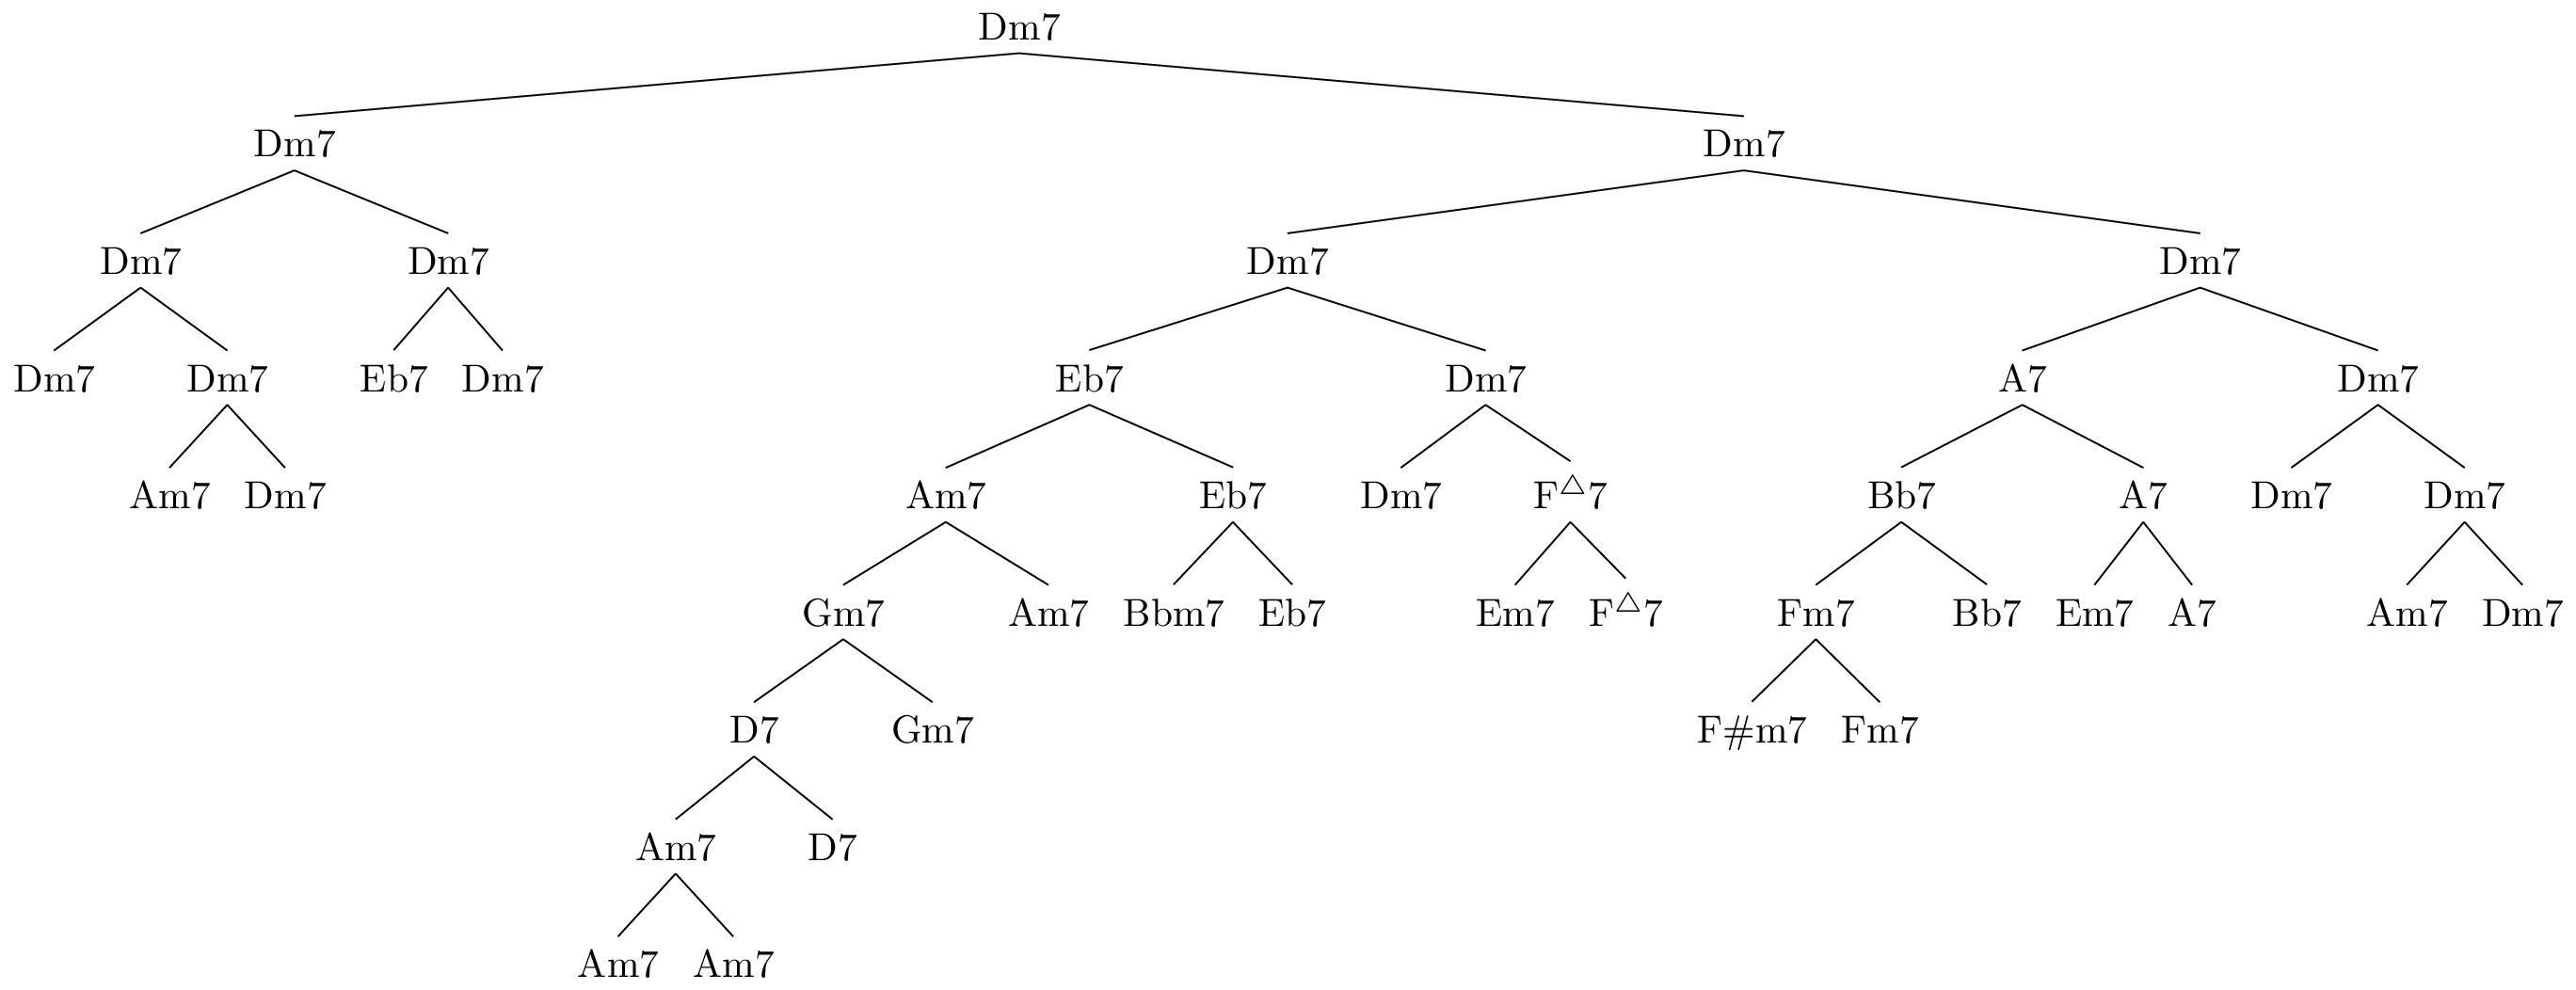

In [30]:
text = """
[.Dm7 [.Dm7 [.Dm7 Dm7 [.Dm7 Am7 Dm7 ] ] [.Dm7 Eb7 Dm7 ] ] [.Dm7 [.Dm7 [.Eb7 [.Am7 [.Gm7 [.D7 [.Am7 Am7 Am7 ] D7 ] Gm7 ] Am7 ] [.Eb7 Bbm7 Eb7 ] ] [.Dm7 Dm7 [.F^7 Em7 F^7 ] ] ] [.Dm7 [.A7 [.Bb7 [.Fm7 F#m7 Fm7 ] Bb7 ] [.A7 Em7 A7 ] ] [.Dm7 Dm7 [.Dm7 Am7 Dm7 ] ] ] ] ]
"""
plotQTree(latex_escape(text), resolution=300)